In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [2]:
def load_arena_pairs(csv_path: str) -> pd.DataFrame:
    """
    Load an Arena-style CSV with columns:
      - id
      - question
      - one column per pair: "<model_a>_vs_<model_b>"
        with values in {0,1,2,3}:
          0: model_a wins
          1: model_b wins
          2: tie
          3: both_bad

    Returns a DataFrame with columns:
      - question_id
      - model_1
      - model_2
      - label  (0,1,2,3)
    """
    df_wide = pd.read_csv(csv_path)

    pair_cols = [c for c in df_wide.columns if "_vs_" in c]

    rows = []
    for _, row in df_wide.iterrows():
        qid = row["id"]
        for col in pair_cols:
            val = row[col]
            # skip missing / NaN entries
            if pd.isna(val):
                continue
            label = int(val)
            model_a, model_b = col.split("_vs_", 1)
            rows.append(
                {
                    "question_id": qid,
                    "model_1": model_a,
                    "model_2": model_b,
                    "label": label,
                }
            )

    arena_pairs = pd.DataFrame(rows)
    arena_pairs[["model_1", "model_2"]] = arena_pairs[["model_1", "model_2"]].replace({
        "gpt-4o-mini-2024-07-18": "gpt-4o-mini",
        "deepseek-chat": "deepseek-v3-0324",
        "llama-3.3-70b-instruct": "llama-3.3-70b-it",
        "gemini-2.0-flash-001": "gemini-2.0-flash"
    })
    
    return arena_pairs

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_difficulty_and_ability(
    model_ranking,
    question_ranking,
    bins: int = 40,
    save_path: str | None = None,
    save: bool = False,
    title: str | None = None,
):
    """
    Stacked histogram of question difficulties (optionally by benchmark)
    with model abilities overlaid.

    Assumes:
      - model_ranking: DataFrame with columns ["model_name", "theta"]
      - question_ranking: DataFrame with columns ["question_id", "difficulty_b"]
        and optionally "benchmark".
        If "benchmark" is missing:
          * rows with question_id containing '_' are treated as static and
            benchmark is inferred as prefix before the last '_'
          * rows without '_' are treated as Arena questions (benchmark = 'Arena')
    """
    plt.style.use("seaborn-v0_8-whitegrid")

    qr = question_ranking.copy()

    # --- handle benchmark column robustly for static + arena ---
    if "benchmark" not in qr.columns:
        qid_str = qr["question_id"].astype(str)
        has_underscore = qid_str.str.contains("_")

        # static-style: "<bench>_<something>"
        bench_static = qid_str.str.rsplit("_", n=1).str[0]

        # arena-style: no underscore -> group as "Arena"
        qr["benchmark"] = np.where(has_underscore, bench_static, "Arena")

    benchmarks = sorted(qr["benchmark"].unique())
    bench_colors = plt.cm.tab10.colors[: len(benchmarks)]

    fig, ax = plt.subplots(figsize=(11, 5.5))

    # ----- stacked histogram of difficulties -----
    b_vals = qr["difficulty_b"].values
    if len(b_vals) == 0:
        raise ValueError("question_ranking appears to be empty.")

    bin_edges = np.linspace(b_vals.min(), b_vals.max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)

    hist_data = []
    for bmk in benchmarks:
        vals = qr.loc[qr["benchmark"] == bmk, "difficulty_b"].values
        hist, _ = np.histogram(vals, bins=bin_edges)
        hist_data.append(hist)
    hist_data = np.array(hist_data)

    bottoms = np.zeros_like(hist_data[0])
    bench_handles = []
    for i, bmk in enumerate(benchmarks):
        ax.bar(
            bin_centers,
            hist_data[i],
            width=bin_widths,
            bottom=bottoms,
            color=bench_colors[i],
            alpha=0.85,
            align="center",
            edgecolor="white",
            linewidth=0.3,
        )
        bottoms += hist_data[i]
        bench_handles.append(Line2D([0], [0], color=bench_colors[i], lw=6, label=bmk))

    y_max = bottoms.max() if len(bottoms) > 0 else 1.0
    ax.set_ylim(0, max(1.0, y_max * 1.7))

    # thin vertical line at 0 for reference
    ax.axvline(0.0, color="k", linestyle=":", linewidth=1.0, alpha=0.4, zorder=0)

    # ----- overlay model abilities -----
    mr_sorted = (
        model_ranking.sort_values("theta", ascending=False)
        .reset_index(drop=True)
    )
    theta_vals = mr_sorted["theta"].values
    model_names = mr_sorted["model_name"].values

    # nice rank labels: 1st, 2nd, 3rd, 4th, ...
    def suffix(i: int) -> str:
        return "st" if i == 0 else "nd" if i == 1 else "rd" if i == 2 else "th"

    rank_labels = [f"{i+1}{suffix(i)}" for i in range(len(model_names))]

    model_colors = plt.cm.Dark2.colors[: len(model_names)]
    model_handles = []

    # where to draw markers vertically
    total_ylim = max(1.0, y_max * 1.7)
    vline_top = y_max * 1.05 / total_ylim
    marker_y = y_max * 1.08
    base_text_y = y_max * 1.18
    text_offset = y_max * 0.04  # to stagger labels

    for i, (theta, name) in enumerate(zip(theta_vals, model_names)):
        color = model_colors[i % len(model_colors)]

        # vertical line
        ax.axvline(
            theta,
            0,
            vline_top,
            color=color,
            linestyle="--",
            linewidth=1.5,
            alpha=0.9,
        )
        # marker
        ax.scatter([theta], [marker_y], color=color, s=55, zorder=5)

        # stagger rank labels slightly in y to reduce overlap
        text_y = base_text_y + ((i % 2) * text_offset)
        ax.text(
            theta,
            text_y,
            rank_labels[i],
            ha="center",
            va="bottom",
            fontsize=8,
            color=color,
            fontweight="medium",
        )

        model_handles.append(
            Line2D(
                [0],
                [0],
                color=color,
                linestyle="--",
                marker="o",
                markersize=5,
                label=f"{rank_labels[i]}: {name}",
            )
        )

    # ----- cosmetics & legends -----
    ax.set_xlabel("Latent scale (ability $\\theta$ / difficulty $b$)", fontsize=11)
    ax.set_ylabel("Number of questions", fontsize=11)

    if title is None:
        title = (
            "Estimated Question Difficulties (Benchmarks and Arena Logs Combined) and Model Strengths"
        )
    ax.set_title(title, fontsize=13, pad=10)

    ax.tick_params(axis="both", labelsize=9)

    # Legend for benchmarks (skip if there's only a single generic bucket)
    if len(benchmarks) > 1 or benchmarks[0] not in ("All questions", "Arena"):
        legend1 = ax.legend(
            handles=bench_handles,
            title="Benchmarks",
            frameon=False,
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            borderaxespad=0.0,
        )
        ax.add_artist(legend1)

    # Legend for models
    ax.legend(
        handles=model_handles,
        title="Models",
        frameon=False,
        bbox_to_anchor=(1.02, 0.4),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=8,
        title_fontsize=9,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92])

    if save_path is not None and save:
        plt.savefig(save_path, dpi=800, bbox_inches="tight")

    plt.show()

In [4]:
def fit_joint_static_arena_irt(
    static_df: pd.DataFrame,
    arena_pairs_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.02,
    lambda_static: float = 1.0,
    lambda_arena: float = 1.0,
    lambda_tie: float = 0.0,   # often 0 or small
    lambda_bb: float = 1.0,
    verbose: bool = True,
):
    """
    Joint model:
      - 2PL IRT on static correctness
          P(correct_{i,q}) = sigmoid(a_q * (theta_i - b_q)),
          with a_q = exp(k_q)

      - Pairwise IRT on arena-style preferences:
          pi_{i,q} = sigmoid(theta_i - b_q)
          z_{ijq}  = a_q * (pi_{i,q} - pi_{j,q})
          P(i > j | q) = sigmoid(z_{ijq})

    Inputs:
      static_df: DataFrame with columns:
        - model_name
        - question_id
        - judge_result (0/1)
      arena_pairs_df: DataFrame with columns:
        - question_id
        - model_1
        - model_2
        - label in {0,1,2,3}:
            0: model_1 wins
            1: model_2 wins
            2: tie
            3: both_bad

    Returns:
      model_params: DataFrame with columns [model_name, theta]
      question_params: DataFrame with [question_id, difficulty_b, k_raw, discrimination_exp_k]
    """

    # ------------------------------------------------------------------
    # 1. Preprocess static & arena data
    # ------------------------------------------------------------------
    static = static_df.copy()
    arena = arena_pairs_df.copy()

    # Map arena labels to outcome strings
    label_to_outcome = {
        0: "m1_win",
        1: "m2_win",
        2: "tie",
        3: "both_bad",
    }
    arena["outcome"] = arena["label"].map(label_to_outcome)

    # Split arena by outcome
    df_win  = arena[arena["outcome"] == "m1_win"].copy()
    df_loss = arena[arena["outcome"] == "m2_win"].copy()
    df_tie  = arena[arena["outcome"] == "tie"].copy()
    df_bb   = arena[arena["outcome"] == "both_bad"].copy()

    # Binary labels for decisive pairs (arena)
    df_win["label_bin"]  = 1.0
    df_loss["label_bin"] = 0.0
    df_dec = pd.concat([df_win, df_loss], axis=0)

    # ------------------------------------------------------------------
    # 2. Unified indexing for models & questions
    # ------------------------------------------------------------------
    # models: union of static & arena
    all_models = pd.Index(
        pd.unique(
            pd.concat(
                [
                    static["model_name"],
                    arena["model_1"],
                    arena["model_2"],
                ],
                ignore_index=True,
            )
        ),
        name="model_name",
    )

    # questions: union of static & arena
    all_questions = pd.Index(
        pd.unique(
            pd.concat(
                [
                    static["question_id"],
                    arena["question_id"],
                ],
                ignore_index=True,
            )
        ),
        name="question_id",
    )

    model_to_idx = {m: i for i, m in enumerate(all_models)}
    q_to_idx = {q: i for i, q in enumerate(all_questions)}

    # --- Static indices ---
    static = static[
        static["model_name"].isin(all_models)
        & static["question_id"].isin(all_questions)
    ].copy()
    static["m_idx"] = static["model_name"].map(model_to_idx)
    static["q_idx"] = static["question_id"].map(q_to_idx)

    # --- Arena indices ---
    def map_indices(sub_df):
        sub_df = sub_df.copy()
        sub_df["m1_idx"] = sub_df["model_1"].map(model_to_idx)
        sub_df["m2_idx"] = sub_df["model_2"].map(model_to_idx)
        sub_df["q_idx"]  = sub_df["question_id"].map(q_to_idx)
        return sub_df

    df_dec = map_indices(df_dec)
    df_tie = map_indices(df_tie) if len(df_tie) > 0 else df_tie
    df_bb  = map_indices(df_bb)  if len(df_bb) > 0 else df_bb

    # ------------------------------------------------------------------
    # 3. Tensors
    # ------------------------------------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Static
    m_static = torch.tensor(static["m_idx"].values).long().to(device)
    q_static = torch.tensor(static["q_idx"].values).long().to(device)
    y_static = torch.tensor(static["judge_result"].values).float().to(device)

    # Arena decisive
    m1_dec = torch.tensor(df_dec["m1_idx"].values).long().to(device)
    m2_dec = torch.tensor(df_dec["m2_idx"].values).long().to(device)
    q_dec  = torch.tensor(df_dec["q_idx"].values).long().to(device)
    y_dec  = torch.tensor(df_dec["label_bin"].values).float().to(device)

    # Arena ties
    if len(df_tie) > 0:
        m1_tie = torch.tensor(df_tie["m1_idx"].values).long().to(device)
        m2_tie = torch.tensor(df_tie["m2_idx"].values).long().to(device)
        q_tie  = torch.tensor(df_tie["q_idx"].values).long().to(device)
    else:
        m1_tie = m2_tie = q_tie = None

    # Arena both_bad
    if len(df_bb) > 0:
        m1_bb = torch.tensor(df_bb["m1_idx"].values).long().to(device)
        m2_bb = torch.tensor(df_bb["m2_idx"].values).long().to(device)
        q_bb  = torch.tensor(df_bb["q_idx"].values).long().to(device)
    else:
        m1_bb = m2_bb = q_bb = None

    n_models = len(all_models)
    n_questions = len(all_questions)

    # ------------------------------------------------------------------
    # 4. Parameters: theta (models), b (questions), k (questions)
    # ------------------------------------------------------------------
    theta = nn.Embedding(n_models, 1, device=device)  # ability
    b     = nn.Embedding(n_questions, 1, device=device)  # difficulty
    k     = nn.Embedding(n_questions, 1, device=device)  # discrimination (log-scale)

    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    optimizer = optim.Adam(
        list(theta.parameters()) + list(b.parameters()) + list(k.parameters()),
        lr=lr,
    )

    bce = nn.BCEWithLogitsLoss()

    # ------------------------------------------------------------------
    # 5. Training loop
    # ------------------------------------------------------------------
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # ===== Static 2PL loss =====
        # P(correct_{i,q}) = sigmoid(a_q * (theta_i - b_q)), a_q = exp(k_q)
        theta_s = theta(m_static).squeeze(-1)  # [N_static]
        b_q_s   = b(q_static).squeeze(-1)      # [N_static]
        k_q_s   = k(q_static).squeeze(-1)      # [N_static]
        a_q_s   = torch.exp(k_q_s)

        logits_static = a_q_s * (theta_s - b_q_s)
        loss_static = bce(logits_static, y_static)

        # ===== Arena decisive (pairwise) =====
        theta_m1 = theta(m1_dec).squeeze(-1)
        theta_m2 = theta(m2_dec).squeeze(-1)
        b_q_dec  = b(q_dec).squeeze(-1)
        k_q_dec  = k(q_dec).squeeze(-1)
        a_q_dec  = torch.exp(k_q_dec)

        # latent correctness probs for pairwise
        pi_m1 = torch.sigmoid(theta_m1 - b_q_dec)
        pi_m2 = torch.sigmoid(theta_m2 - b_q_dec)

        z_dec = a_q_dec * (pi_m1 - pi_m2)
        loss_dec = bce(z_dec, y_dec)

        # ===== Arena ties (optional) =====
        if lambda_tie > 0.0 and m1_tie is not None and len(m1_tie) > 0:
            theta_m1_t = theta(m1_tie).squeeze(-1)
            theta_m2_t = theta(m2_tie).squeeze(-1)
            b_q_t      = b(q_tie).squeeze(-1)
            k_q_t      = k(q_tie).squeeze(-1)
            a_q_t      = torch.exp(k_q_t)

            pi_m1_t = torch.sigmoid(theta_m1_t - b_q_t)
            pi_m2_t = torch.sigmoid(theta_m2_t - b_q_t)

            z_tie = a_q_t * (pi_m1_t - pi_m2_t)
            y_tie = torch.full_like(z_tie, 0.5)
            loss_tie = bce(z_tie, y_tie)
        else:
            loss_tie = torch.tensor(0.0, device=device)

        # ===== Arena both_bad =====
        if lambda_bb > 0.0 and m1_bb is not None and len(m1_bb) > 0:
            theta_m1_bb = theta(m1_bb).squeeze(-1)
            theta_m2_bb = theta(m2_bb).squeeze(-1)
            b_q_bb      = b(q_bb).squeeze(-1)

            pi_m1_bb = torch.sigmoid(theta_m1_bb - b_q_bb)
            pi_m2_bb = torch.sigmoid(theta_m2_bb - b_q_bb)

            loss_bb = (
                -torch.log(1 - pi_m1_bb + 1e-6).mean()
                -torch.log(1 - pi_m2_bb + 1e-6).mean()
            )
        else:
            loss_bb = torch.tensor(0.0, device=device)

        # ===== L2 regularization =====
        reg = 1e-4 * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
            + k.weight.pow(2).mean()
        )

        # ===== Total loss =====
        total_loss = (
            lambda_static * loss_static
            + lambda_arena * (loss_dec + lambda_tie * loss_tie + lambda_bb * loss_bb)
            + reg
        )

        total_loss.backward()
        optimizer.step()

        # Identifiability: center theta, shift b
        with torch.no_grad():
            shift = theta.weight.mean()
            theta.weight.sub_(shift)
            b.weight.sub_(shift)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(
                f"Epoch {epoch:4d} | "
                f"static={loss_static.item():.4f}  "
                f"dec={loss_dec.item():.4f}  "
                f"tie={loss_tie.item():.4f}  "
                f"bb={loss_bb.item():.4f}  "
                f"total={total_loss.item():.4f}"
            )

    # ------------------------------------------------------------------
    # 6. Extract parameters
    # ------------------------------------------------------------------
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np     = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np     = k.weight.detach().cpu().numpy().squeeze(-1)
    disc_np  = np.exp(k_np)

    model_params = (
        pd.DataFrame({"model_name": all_models, "theta": theta_np})
        .sort_values("theta", ascending=False)
        .reset_index(drop=True)
    )

    question_params = (
        pd.DataFrame(
            {
                "question_id": all_questions,
                "difficulty_b": b_np,
                "k_raw": k_np,
                "discrimination_exp_k": disc_np,
            }
        )
        .sort_values("difficulty_b", ascending=False)
        .reset_index(drop=True)
    )

    return model_params, question_params


In [5]:
static_df = pd.read_csv("./data/static_10_models.csv")
arena_pairs_df = load_arena_pairs("./data/pairwise_results_900.csv")

model_params_joint, question_params_joint = fit_joint_static_arena_irt(
    static_df,
    arena_pairs_df,
    num_epochs=5000,
    lr=0.05,
    lambda_static=1.0,
    lambda_arena=1.0,
    lambda_tie=0.0,   # ignore ties initially if you like
    lambda_bb=0.3,
    verbose=True,
)

Epoch    0 | static=0.6931  dec=0.6931  tie=0.0000  bb=1.3863  total=1.8022
Epoch  500 | static=0.3784  dec=0.5207  tie=0.0000  bb=0.0155  total=0.9060
Epoch 1000 | static=0.3693  dec=0.5117  tie=0.0000  bb=0.0083  total=0.8871
Epoch 1500 | static=0.3632  dec=0.5042  tie=0.0000  bb=0.0052  total=0.8740
Epoch 2000 | static=0.3707  dec=0.5009  tie=0.0000  bb=0.0045  total=0.8795
Epoch 2500 | static=0.3660  dec=0.4942  tie=0.0000  bb=0.0029  total=0.8691
Epoch 3000 | static=0.3671  dec=0.4912  tie=0.0000  bb=0.0024  total=0.8686
Epoch 3500 | static=0.3716  dec=0.4918  tie=0.0000  bb=0.0023  total=0.8751
Epoch 4000 | static=0.3685  dec=0.4885  tie=0.0000  bb=0.0016  total=0.8694
Epoch 4500 | static=0.3716  dec=0.4921  tie=0.0000  bb=0.0017  total=0.8765
Epoch 4999 | static=0.3681  dec=0.4877  tie=0.0000  bb=0.0014  total=0.8688


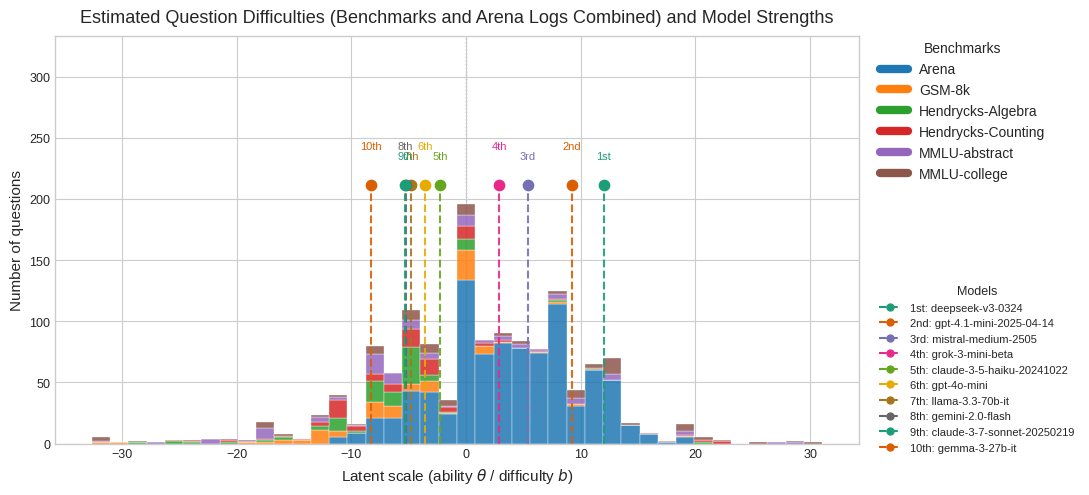

In [7]:
plot_difficulty_and_ability(model_params_joint, question_params_joint, save_path="./figures/combined_ranking_900.png", save=True)

In [103]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def evaluate_joint_model_with_confusion_and_heatmap(
    static_df: pd.DataFrame,
    arena_pairs_df: pd.DataFrame,
    model_params_joint: pd.DataFrame,
    question_params_joint: pd.DataFrame,
    tie_margin: float = 0.05,
    both_bad_thresh: float = 0.2,
    plot_heatmap: bool = True,
):
    """
    Compute static accuracy, arena accuracy, 4x4 confusion matrix,
    and a reduced 3x3 confusion matrix (removing the tie category).
    Optionally draw the 3x3 heatmap.
    """

    # --------------------------------------------------
    # Map parameters
    # --------------------------------------------------
    theta_map = model_params_joint.set_index("model_name")["theta"]
    b_map = question_params_joint.set_index("question_id")["difficulty_b"]

    # --------------------------------------------------
    # 1. STATIC EVALUATION
    # --------------------------------------------------
    static = static_df.copy()
    static["theta"] = static["model_name"].map(theta_map)
    static["b"] = static["question_id"].map(b_map)
    static = static.dropna(subset=["theta", "b", "judge_result"])
    static["pred_correct"] = (static["theta"] >= static["b"]).astype(int)
    static_fraction_correct = (static["pred_correct"] == static["judge_result"]).mean()

    # --------------------------------------------------
    # 2. ARENA EVALUATION + PREDICTIONS
    # --------------------------------------------------
    arena = arena_pairs_df.copy()
    arena["theta_1"] = arena["model_1"].map(theta_map)
    arena["theta_2"] = arena["model_2"].map(theta_map)
    arena["b"] = arena["question_id"].map(b_map)
    arena = arena.dropna(subset=["theta_1", "theta_2", "b", "label"])
    arena["label"] = arena["label"].astype(int)

    # latent correctness probabilities
    pi1 = sigmoid(arena["theta_1"].to_numpy() - arena["b"].to_numpy())
    pi2 = sigmoid(arena["theta_2"].to_numpy() - arena["b"].to_numpy())

    true_label = arena["label"].to_numpy()
    pred_label = np.zeros_like(true_label)

    # both_bad
    both_bad_mask = (pi1 < both_bad_thresh) & (pi2 < both_bad_thresh)
    pred_label[both_bad_mask] = 3

    # tie
    tie_mask = (~both_bad_mask) & (np.abs(pi1 - pi2) < tie_margin)
    pred_label[tie_mask] = 2

    # decisive
    undecided_mask = ~(both_bad_mask | tie_mask)
    pred_label[undecided_mask & (pi1 > pi2)] = 0
    pred_label[undecided_mask & (pi2 >= pi1)] = 1

    non_tie_mask = true_label != 2
    if non_tie_mask.any():
        arena_fraction_correct = (
            pred_label[non_tie_mask] == true_label[non_tie_mask]
        ).mean()
    else:
        arena_fraction_correct = np.nan  # no non-tie examples

    # --------------------------------------------------
    # 3. FULL 4×4 CONFUSION MATRIX
    # --------------------------------------------------
    labels = [0, 1, 2, 3]
    confusion4 = pd.crosstab(
        pd.Series(true_label, name="true"),
        pd.Series(pred_label, name="pred"),
        rownames=["true"], colnames=["pred"],
        dropna=False,
    ).reindex(index=labels, columns=labels, fill_value=0)

    confusion4_norm = confusion4.div(confusion4.sum(axis=1).replace(0, np.nan), axis=0)

    # --------------------------------------------------
    # 4. REDUCED 3×3 CONFUSION MATRIX (REMOVE TIE=2)
    # --------------------------------------------------
    labels_3 = [0, 1, 3]   # remove label 2
    confusion3 = confusion4.loc[labels_3, labels_3]
    confusion3_norm = confusion3.div(confusion3.sum(axis=1).replace(0, np.nan), axis=0)

    # --------------------------------------------------
    # 5. HEATMAP OF 3×3 CONFUSION (OPTIONAL)
    # --------------------------------------------------
    if plot_heatmap:
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            confusion3_norm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=["m1_win", "m2_win", "both_bad"],
            yticklabels=["m1_win", "m2_win", "both_bad"],
        )
        plt.title("Confusion Matrix for Pairwise Preference Reconstruction (row-normalized)")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.tight_layout()
        plt.savefig("./figures/confusion_matrix_arena.pdf", dpi=500, bbox_inches="tight")
        plt.show()

    # --------------------------------------------------
    # RETURN ALL STATS
    # --------------------------------------------------
    return {
        "static_fraction_correct": float(static_fraction_correct),
        "arena_fraction_correct": float(arena_fraction_correct),
        "arena_confusion_4x4": confusion4,
        "arena_confusion_4x4_normalized": confusion4_norm,
        "arena_confusion_3x3": confusion3,
        "arena_confusion_3x3_normalized": confusion3_norm,
    }


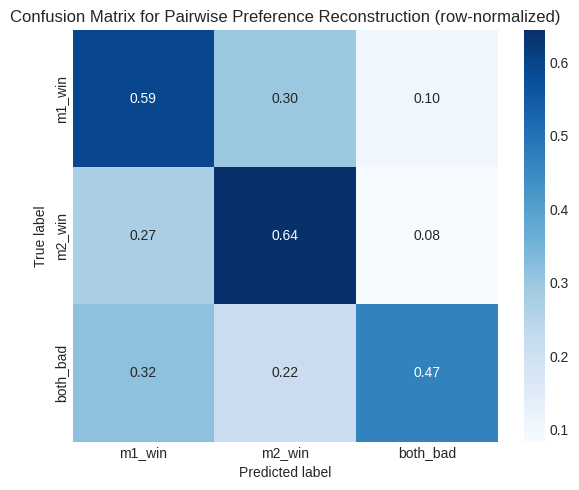

Static correct fraction: 0.7998
Arena correct fraction: 0.624061339024583
Full 4×4 confusion:
 pred     0     1  2    3
true                    
0     2864  1446  0  504
1     2112  4994  0  652
2     2181  2650  0  248
3       25    17  0   37
Reduced 3×3 confusion:
 pred     0     1    3
true                 
0     2864  1446  504
1     2112  4994  652
3       25    17   37


In [106]:
metrics = evaluate_joint_model_with_confusion_and_heatmap(
    static_df,
    arena_pairs_df,
    model_params_joint,
    question_params_joint,
    tie_margin=0.0,
    both_bad_thresh=5e-6,
)

print("Static correct fraction:", metrics["static_fraction_correct"])
print("Arena correct fraction:", metrics["arena_fraction_correct"])
print("Full 4×4 confusion:\n", metrics["arena_confusion_4x4"])
print("Reduced 3×3 confusion:\n", metrics["arena_confusion_3x3"])